In [1]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from io import BytesIO
import persistable
import hdbscan
import seaborn as sns
import gudhi
from gudhi.clustering.tomato import Tomato
import persistable
import genieclust
from sklearn import metrics
import pandas as pd
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import random
import warnings
import matplotlib

# Useful functions

In [15]:
warnings.filterwarnings("ignore")
stat = pd.DataFrame(columns=['algo', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

In [16]:
stat = pd.DataFrame(columns=['algo', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])
def stat_filling(data, labels, algName, stat):
  row = {'algo' : algName,
         'silhouette' : metrics.silhouette_score(data, labels, metric='euclidean'),
         'calinski_harabasz' : metrics.calinski_harabasz_score(data, labels),
         'davies_bouldin' : metrics.davies_bouldin_score(data, labels)}
  stat = pd.concat([stat, pd.DataFrame([row])], ignore_index=True)
  return stat

# DATA

No transformations will be applied to data, as by creation it is represented in the form suitable for clustering.

In [4]:
data = np.load("X_hdbscan.npy")

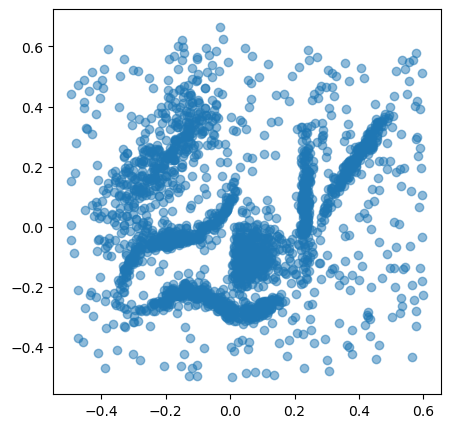

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(data[:,0], data[:,1], alpha=0.5)
plt.show()

# HDBSCAN

It is a modification to a DBSCAN algorithm, which performs hierarchical clustering. It allows to ease the procedure of parameter choice.

Input parameters: `alpha`, `approx_min_span_tree`,
    `gen_min_span_tree`, `leaf_size`, `memory`,
    `metric`, `min_cluster_size`, `min_samples`, `p` \
Where the most result influencing is `min_cluster_size`, which is an intuitive parameter. 

Short TDA description: Persistent homology H0 (number of connected components in a complex) over distances for a Degree-Rips complex with a fixed min_cluster_size. Special handling of a merge tree for flat cluster extraction.

Algorithm:
- Apply robust single linkage clustering to receive a merge tree.
- Prune the tree, based on the min_cluster_size parameter. Go through the merge tree starting from the root. Each time the split creates a cluster with a number of points less than min_cluster_size, write the distance at which points 'fall out' to the respective node.
- Cluster extraction. Define $\lambda = \frac{1}{distance}$. Starting from the leaves calculate stability of each cluster by the formula: $\sum_{p\in\text{cluster}}^{}\lambda_{fallout} - \lambda_\text{birth}$. In case the merged cluster has smaller stability than the sum of the child clusters, continue the process. If a merged cluster has greater stability, choose it as the final cluster and do not choose all descendants.
  
Advantages: allows variable density clustering, robust to outliers, easy parameter to select, stable, able to detect noisy points. \
Disadvantages: density is poorly defined in high dimensions, detection of noise points negatively affects metrics. 


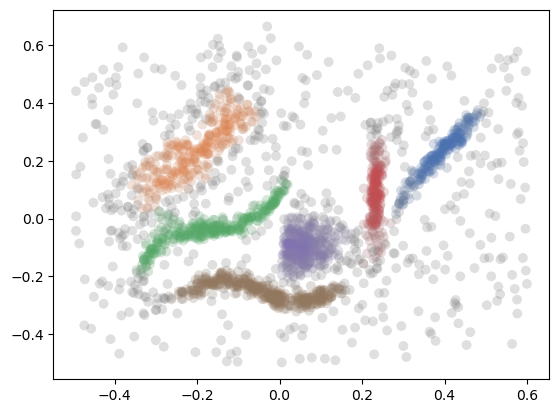

In [6]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, gen_min_span_tree=True)
clusterer.fit(data)
color_palette = sns.color_palette('deep', 20)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25);
stat = stat_filling(data, clusterer.labels_, 'HDBSCAN', stat)

# ToMATo

Discrete setting will be considered to make algorithm easier to comprehend. 

Input parameters: `graph_type`,
            `density_type` ,
            `metric`,
            `kde_params`, 
            `k` ,
            `k_DTM`, 
            `r`, 
            `eps`, 
            `n_clusters`, 
            `merge_threshold`, 
            `symmetrize_graph`, 
            `p`, 
            `q`, 
            `dim` ,
            `n_jobs`, 
            `params` \
There are many datatype specific parameters, which should be found taking into account data distributions. 
`merging parameter` $\tau$ is hard to be chosen, thus, authors sugest to run algorithm twice. Firstly, set $\tau$ to +infinity. After that use persistence diagram to optimize parameters.

TDA connection: Algorithm uses mode-seeking algorithm to form initial clusters and build persistance diagram. Clusters are created based on their prominence, where important role plays `merging parameter`, which outlines minimum prominence cluster should have.

Algorithm:
- Use given density estimator to estimate density at each point.
- Mode-seeking. Sort points by decreasing density value, connect each vertex to a neighbour with highest density. If there are no such - point is a peak. As a result receive spanning forest of the graph. 
- Merging. Introduce some notations: e - entry of a union-find data structure, r(e) - point in e with highest density, f(i) - density at a point i. Iterate over vertices in the decreasing density order. \
    a) First case: vertex i is a peak(vertex with a highest density in its spanning tree). Then, create new entry $e_i$ in union-find data structure containing the whole spanning tree of this vertex.\
    b) Second case: vertex i is not a peak. Then, i is already present in union-find and belongs to $e_j$. Iterate over neighbours(k) of i for which $f(i) \ge f(k)$. In case merge rule $f(r(e_k)) < min\{f(r(e_j)), f(i)+\tau\}$ is satisfied, merge $e_k$ into $e_j$.
  
Advantages: good performance for noisy data, performs well for non-spherical and non-convex clusters, identifies points not belonging to any cluster. \
Disadvantages: density is poorly defined in high dimensions, has several non-obvious hyper-parameters.

By taking default parameters, 5 points look to be further from the line. Thus, 5 clusters are taken.

There are 100 initial clusters


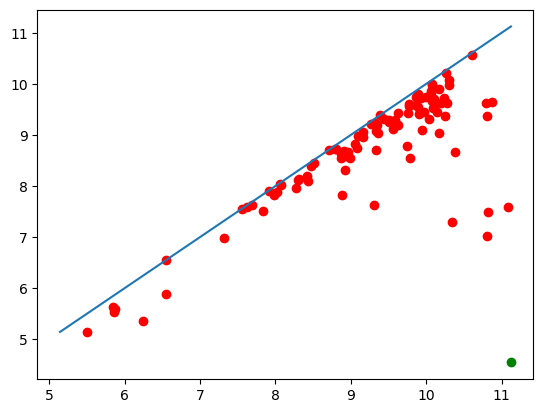

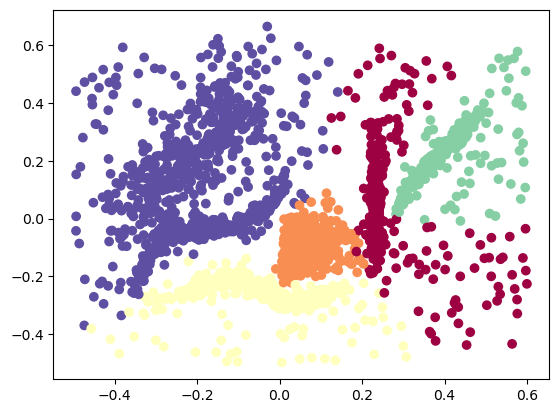

In [7]:
clusterer = Tomato()
clusterer.fit(data)
print("There are " + str(clusterer.n_clusters_) + " initial clusters")
clusterer.plot_diagram()

clusterer.n_clusters_=5
n = clusterer.n_clusters_
labels = clusterer.labels_

norm = plt.Normalize(vmin=0, vmax=n-1)

cmap = plt.cm.Spectral;
fig, ax = plt.subplots();

ax.cla();
ax.scatter(*zip(*data), c=cmap(norm(labels)));
stat = stat_filling(data, clusterer.labels_, 'ToMATo1', stat)

Let's try to adjust some of the parameters to separate purple cluster in 2. Search presented below allows to find optimal k and bandwidth. But it is, also, important to search for graph_type and density_type, as they affect results greatly.

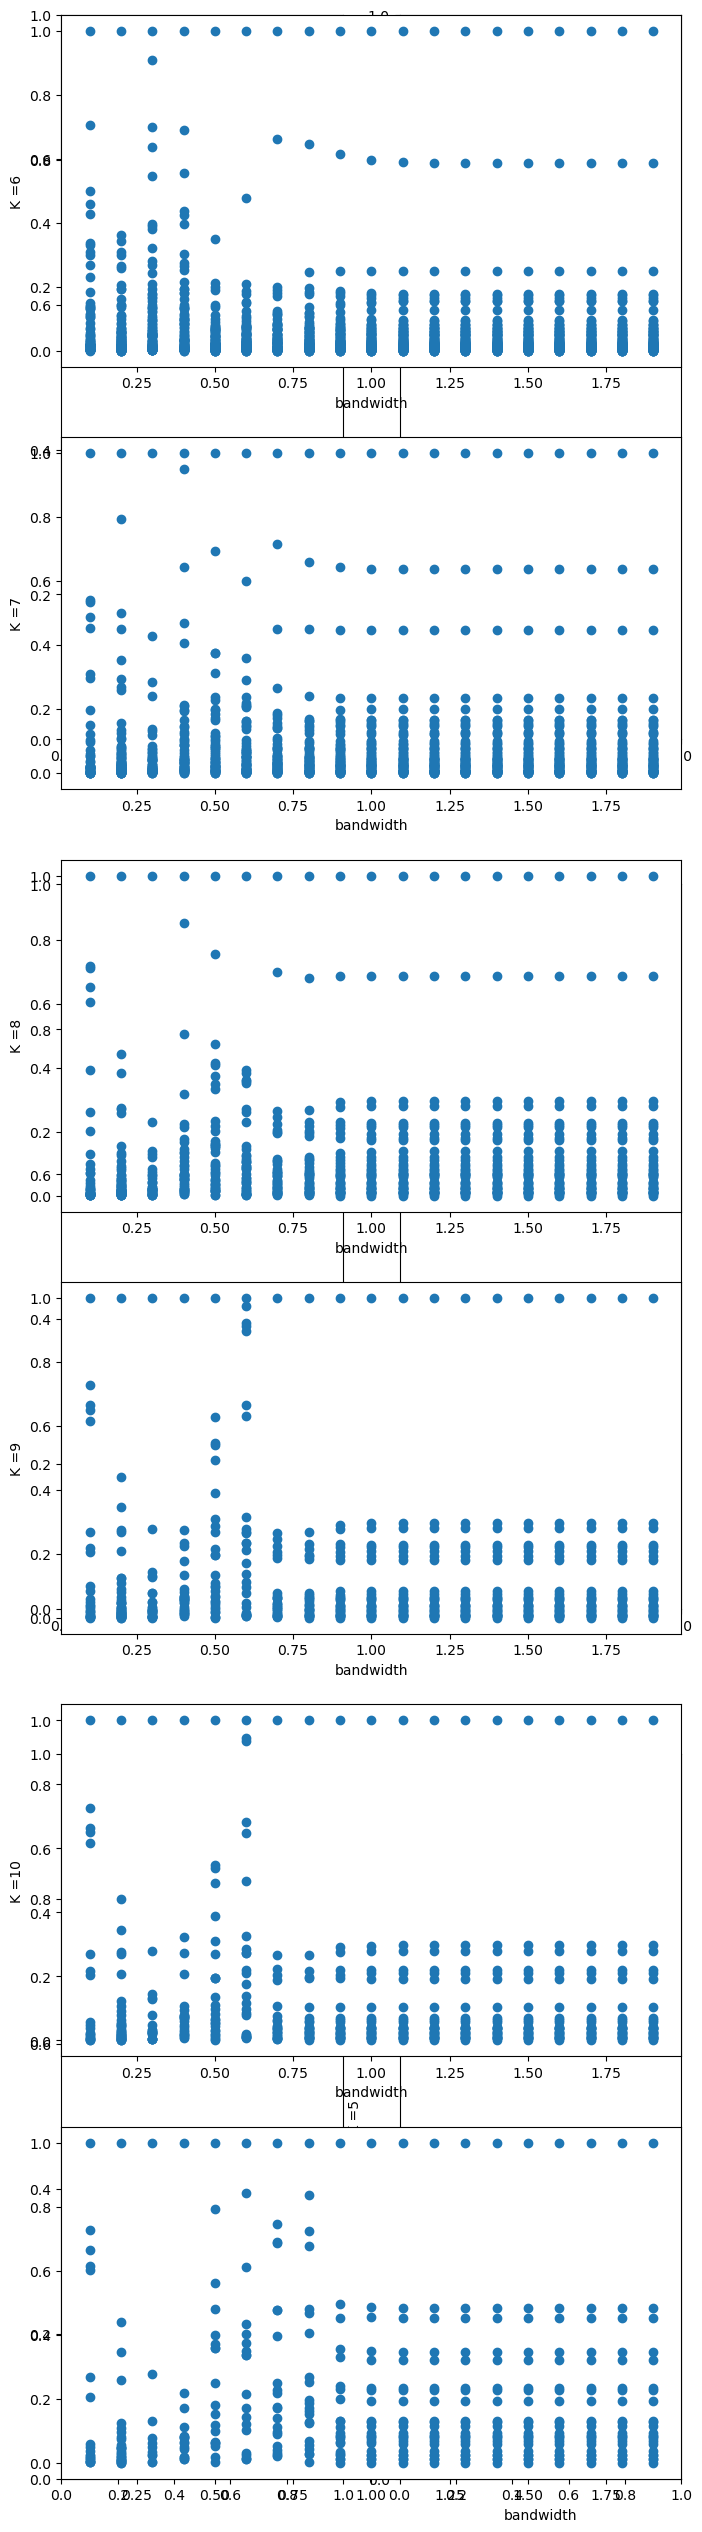

In [8]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)

for n_neigh in range(6,12):
    n_diagram = []
    x_diagram = []
    y_diagram = []
    bandwidth_values = [0.1, 2, 0.1]
    bandwidth = bandwidth_values[0]

    while bandwidth < bandwidth_values[1]:
        ex2 = Tomato(
        input_type="points",
        metric="euclidean",
        graph_type="knn",
        density_type="KDE",
        kde_params = {"bandwidth": bandwidth, "kernel": "epanechnikov"},
        k=n_neigh,
        eps=0.05,
    )
        ex2.fit(data)
        init_clusters = len(ex2.diagram_)
        prominences = np.zeros(init_clusters)
        for i in range(init_clusters):
            prominences[i] = ex2.diagram_[i,0] - ex2.diagram_[i,1]
        max_prom = np.max(prominences)
        for i in range(init_clusters):
            prominences[i] /= max_prom

        n_diagram.append(prominences)
        bandwidth += bandwidth_values[2]


    for i in range(len(n_diagram)):
        for j in range(len(n_diagram[i])):
            x_diagram.append(bandwidth_values[0] + i*bandwidth_values[2])
            y_diagram.append(n_diagram[i][j])

    plt.ylabel('K =' + str(n_neigh-1))
    plt.xlabel('bandwidth')
    plt.subplot(6, 1, n_neigh-5)
    plt.scatter(x_diagram, y_diagram)

fig = plt.gcf()
fig.set_size_inches(8, 32)
plt.show()

There are 7 initial clusters


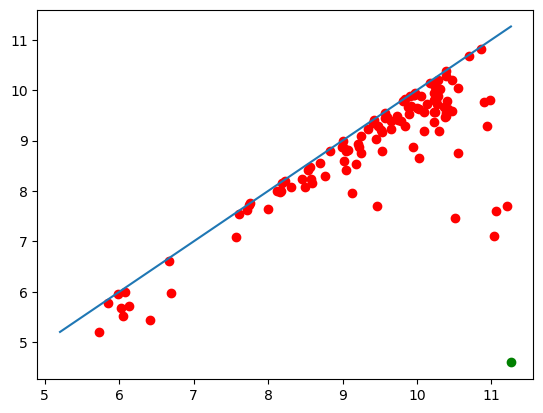

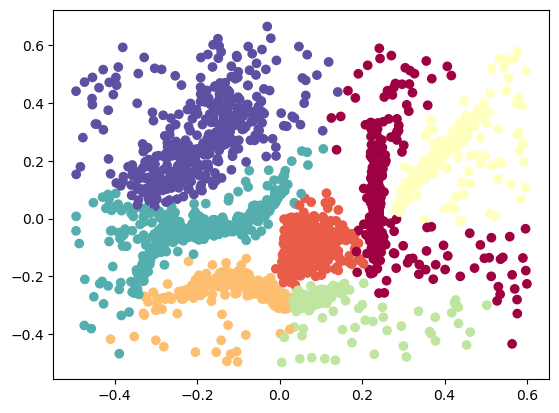

In [9]:
clusterer = Tomato(
        input_type="points",
        metric="euclidean",
        graph_type="knn",
        density_type="logDTM",
        kde_params = {"bandwidth": 0.6, "kernel": "epanechnikov"},
        n_clusters=7,
        k=9,
#         eps=0.05,
    )

clusterer.fit(data)

print("There are " + str(clusterer.n_clusters_) + " initial clusters")
clusterer.plot_diagram()
n = clusterer.n_clusters_
labels = clusterer.labels_

norm = plt.Normalize(vmin=0, vmax=n-1)

cmap = plt.cm.Spectral;
fig, ax = plt.subplots();

ax.cla();
ax.scatter(*zip(*data), c=cmap(norm(labels)));
stat = stat_filling(data, clusterer.labels_, 'ToMATo2', stat)

Thus, we get two versions of clustering that seem to distinguish clusters well. But both of them have their own problems and we have look at the metrics to compare them.

# Genie

Genie algorithm is aimed to diminish drawbacks of single linkage clustering and remain its computational effectiveness. To be exact, tackle the problem of some clusters being too large. It can be proven that the Genie linkage criterion can be implemented based on an MST. Thus, Genie clustering is extremely similar to single linkage clustering, however, it uses another linkage criterion. 

Genie linkage criterion: \
Introduce some notation: F - inequity measure, g - threshold in range (0,1].\
If F(current clusters' cardinalities) $\le$ g, apply single linkage criterion. Otherwise, $ L(A,B) = min(d(i, j))\; i \in A, j \in B$, where A or B is of the smallest possible size at the current step.

Input parameters: `n_clusters`, `gini_threshold`, `M`, `affinity`, `exact`, `compute_full_tree`, `compute_all_cuts`, `postprocess`, `cast_float32`, `mlpack_enabled`, `mlpack_leaf_size`, `nmslib_n_neighbors`, `nmslib_params_init`, `nmslib_params_index`, `nmslib_params_query`, `verbose` \
Number of clusters is one of the most important parameters and by only adjusting it good out-of-the-box solution can be obtained.

Algorithm:
- Consider each data point as a separate cluster.
- Build a minimum spanning tree on this set.
- Use union-find data structure to find clusters (for that merge sets with the least genie linkage distance). On each step add merged sets to a dendogram.
- Return clusters at the step when current number of cluster is equal to prespecified number.
  
Advantages: simple, fast, provides good results on many datasets, does not require complicated parameter optimization \
Disadvantages: poor performance for extremely complicated datasets.


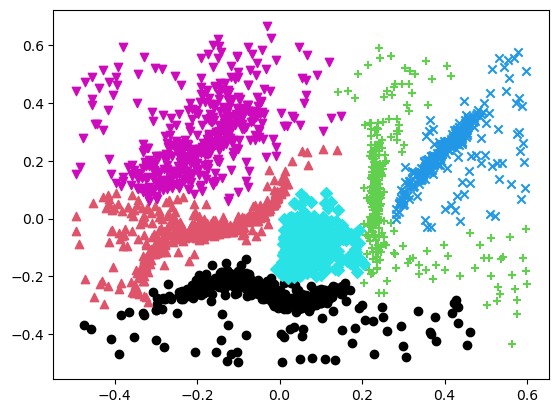

In [10]:
clusterer = genieclust.Genie(n_clusters=6, gini_threshold=0.2)
labels = clusterer.fit_predict(data)

genieclust.plots.plot_scatter(data, labels=labels)
stat = stat_filling(data, clusterer.labels_, 'Genie', stat)

# Persistable

Density-based clustering algorithm aimed to exploratory data analysis.

Input parameters: `n_neighbors` 

TDA connection: Persistable creates a bifiltration based on distance and density parameter combinations. After that it uses slicing technique to create a vineyard of several slices, where prominence can be examined. Algorithm uses data prominence to extract clusters.

Algorithm:
- Consider parameters k - number of neighbours, s - distance threshold.\
    a) Construct subsets of G, X = $\{x \in X | |B(x,s)| >= k\}$ \
    b) Connect points of X if $d(x_i, x_j) <= s$\
    c) Calculate number of connected components. \
    d) Repeat the procedure for all k, s. \
    e) Show component counting function at the graph. 
- Reduce 2-parameter hierarchy to 1-parameter by taking a slice. Slope of the slice is always less than 0. To choose a slice do the following:\
    a) Choose 2 slices. Better to choose one in region with many clusters and the second one with few clusters.\
    b) Compute prominance vineyard - graph, which shows for each possible slice in the chosen range, how long each cluster persists. Figure 2.\
    c) It is desirable to separate more prominent clusters from less prominent. For that choose 2nd largest gap (log prominence scale may help with it) at the vineyard and parameter line where this gap is large.
- Cluster extraction. Extract number of clusters equal to gap number. For that use persistence-based flattening algorihthm. \
    a) Prune the tree.\
    b) Take leaf clustering.
  
Advantages: visualization capabilities \
Disadvantages: long cluster extraction time for large datasets

In [11]:
p = persistable.Persistable(data, n_neighbors="all")
pi = persistable.PersistableInteractive(p)
port = pi.start_ui(jupyter_mode='inline')

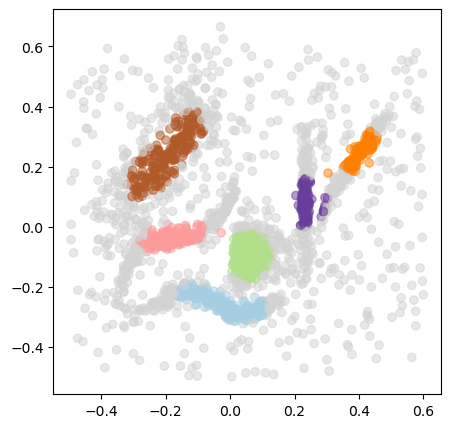

In [13]:
cluster_labels = pi.cluster()
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=np.amax(cluster_labels))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='Paired')
noise_color = (211/255, 211/255, 211/255, 1) # light grey

# plot data with clusters indicated by colors
plt.figure(figsize=(5,5))
plt.scatter(data[:,0], data[:,1], c=[noise_color if x==-1 else scalarMap.to_rgba(x) for x in cluster_labels], alpha=0.5)

plt.show()
stat = stat_filling(data, cluster_labels, 'Persistable', stat)

# DeBacl

Python version of this algorithm is incompatible with other algorithms, thus, only description is presented.

Algorithm for estimation of density level set trees and nonparametric DEnsity-BAsed CLustering.
The level set tree of a probability density function (pdf) concisely represents the hierarchy of the function’s modes.

Input parameters: `X` - 2-dimensional numpy array, `k` - number of neighbours, `prune_threshold`, optional(`first-k`, `k-level`):number of clusters, optional(`Upper-level-set`):threshold for cutting the tree, optional(`Upper-level-set`):form\{'density', 'mass'\} which threshold is applied to.

Algorithm:
- Constuct level set tree either from tabular data or from a similarity graph and density estimate. Let's focus on tabular data, as it involves the latter algorithm. 
    a)Construct KNN similarity graph, estimate KNN density at each point(f(x)).\
    b)Initialise level set tree with estimated density and number of density levels(can be passed as hyperparameter, otherwise, set to number of rows in X.\
    c)For each point j compute set of point L such that $L_j$ = $\{x_i:f(x_i)\ge f(x_j)\}$. Find subgraph $G_j$ induced by $L_j$. Find connected components of $G_j$.
    d)Construct dendogram of all connected components of resulting graphs $G_i$.
- Prune the tree. Use prune_threshold parameter stating minimum number of elements in a cluster. For pruning, merge small leaves into near nodes.
- Extract clusters. DeBacl library includes several implementations of cluster extraction.\
    a)Leaf. Default method, which returns each leaf as a separate cluster. \
    b)First-k. Return as final clusters first K non-overlapping clusters starting from the root.\
    c)Upper-level-set. Clusters received from cutting the tree at specified density or mass.\
    d)K-level. Final clusters are formed by sets at lowest density having k nodes.
  
Advantages: can be applied to large data quite fast \
Disadvantages: lach of version support

# Results Comparison

It is important to consider combination of the metrics, as results based purely on one of them may be unreliable. Also, it is useful to discuss visual representations for datasets where it is possible.

In [14]:
stat

,algo,silhouette,calinski_harabasz,davies_bouldin
0,HDBSCAN,0.213112,390.943927,2.015223
1,ToMATo1,0.296375,1301.696467,1.035304
2,ToMATo2,0.355979,1569.354687,0.983970
3,Genie,0.334083,1626.713991,1.039323
4,Persistable,0.040546,206.188422,1.772312
